<a href="https://colab.research.google.com/github/janjdev/Artificial-Intelligence-CS-5300-/blob/main/Data_Analysis_%26_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intrusion Detection**
### Training multiple models to detect anamolies in network traffic and reduce false positives

## **Preparation**

In [1]:
#Import modules
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import get_file
from sklearn.preprocessing import OneHotEncoder
from functools import *



In [2]:
#Data Sources 
#KDD Cup 1999: Computer network intrusion detection:https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data
#Features:http://kdd.org/cupfiles/KDDCupData/1999/kddcup.names
#Training Attack-types:http://kdd.org/cupfiles/KDDCupData/1999/training_attack_types
#Training Data - 10%:http://kdd.org/cupfiles/KDDCupData/1999/kddcup.data_10_percent.zip

train = get_file('kddcup.data_10_percent.gz', origin=\
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
names = get_file('kddcup.names', origin=\
    'http://kdd.org/cupfiles/KDDCupData/1999/kddcup.names')
ataks = get_file('training_attack_types', origin=\
    'http://kdd.org/cupfiles/KDDCupData/1999/training_attack_types')



16384/272 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [3]:
from numpy.testing._private.utils import tempdir

#Funtion to format the data
def formatData():
  #split column names at each line
  f=open(names, 'r')
  data=f.readlines()[1:]
  column_names=[]
  
  #seperate names from descriptions
  for line in data:
    column_names.append(line.split(':')[0])
  
  #Add missing column name
  column_names.append('outcome')
  f.close()  
  
  #split attack types names at each line
  f=open(ataks, 'r')
  data=f.readlines()[:-1]
  
  #create a dictionary to map attack types
  atck_typ_map={'normal':'normal'}
  
  #for each attack type map attck name to the attck type 
  for line in data:
    k,v=line.split()
    atck_typ_map[k]=v 
  f.close()
  
  #map columns in the datset to the feature names
  temp=pd.read_csv(train,names=column_names)
 
  return temp

#Fix mixed values
def mixedValues(data):
  mixedCol = []
  for col in data.columns:
    weird = (data[[col]].applymap(type) != data[[col]].iloc[0].apply(type)).any(axis=1)
 
  #if mixed values push col to the array
    if len(data[weird]) > 0:
        mixedCol.append(str(col))  
  
  #get each unique value in the column   
  for col in mixedCol:
    uniqEl = data[col].unique()

  #try to cast values as ints else drop the row
    for el in uniqEl:
      try:
        int(el)
      except:
        i = data[data[col]== str(el)].index.values        
        data.drop(i, inplace=True)        
  
  #set the dtype on the columns after removing non-numeric values
    data = data.astype({str(col): int})  
  return data



#**Exploratory Data Analysis (EDA)**

In [4]:
#create dataset
dataset = mixedValues(formatData())
#Note: Mixed values are cleaned in the mixedValues function.


In [5]:
# Exploring the dataset
print("Number of Example (rows): %s" % dataset.shape[0])
print("Number of Features (columns): %s" % dataset.shape[1])

Number of Example (rows): 494021
Number of Features (columns): 42


In [6]:
# View data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [7]:
#Remove duplicates and rows with any N/A values
dataset.drop_duplicates(inplace=True)
dataset.dropna(inplace=True)

# Inspecting the dataset
dataset.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


In [8]:
# Check if dataset free from null values
print('')
dataset.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [9]:
#Encode Nominal Variable (Categorical) Data (protocol_type, service, flag, outcome)

ec = OneHotEncoder(drop='first',sparse=False)
dataset['protocol_type'] = ec.fit_transform(dataset['protocol_type'].values.reshape(-1, 1))
dataset['service'] = ec.fit_transform(dataset['service'].values.reshape(-1, 1))
dataset['flag'] = ec.fit_transform(dataset['flag'].values.reshape(-1, 1))
dataset['outcome'] = ec.fit_transform(dataset['outcome'].values.reshape(-1, 1))

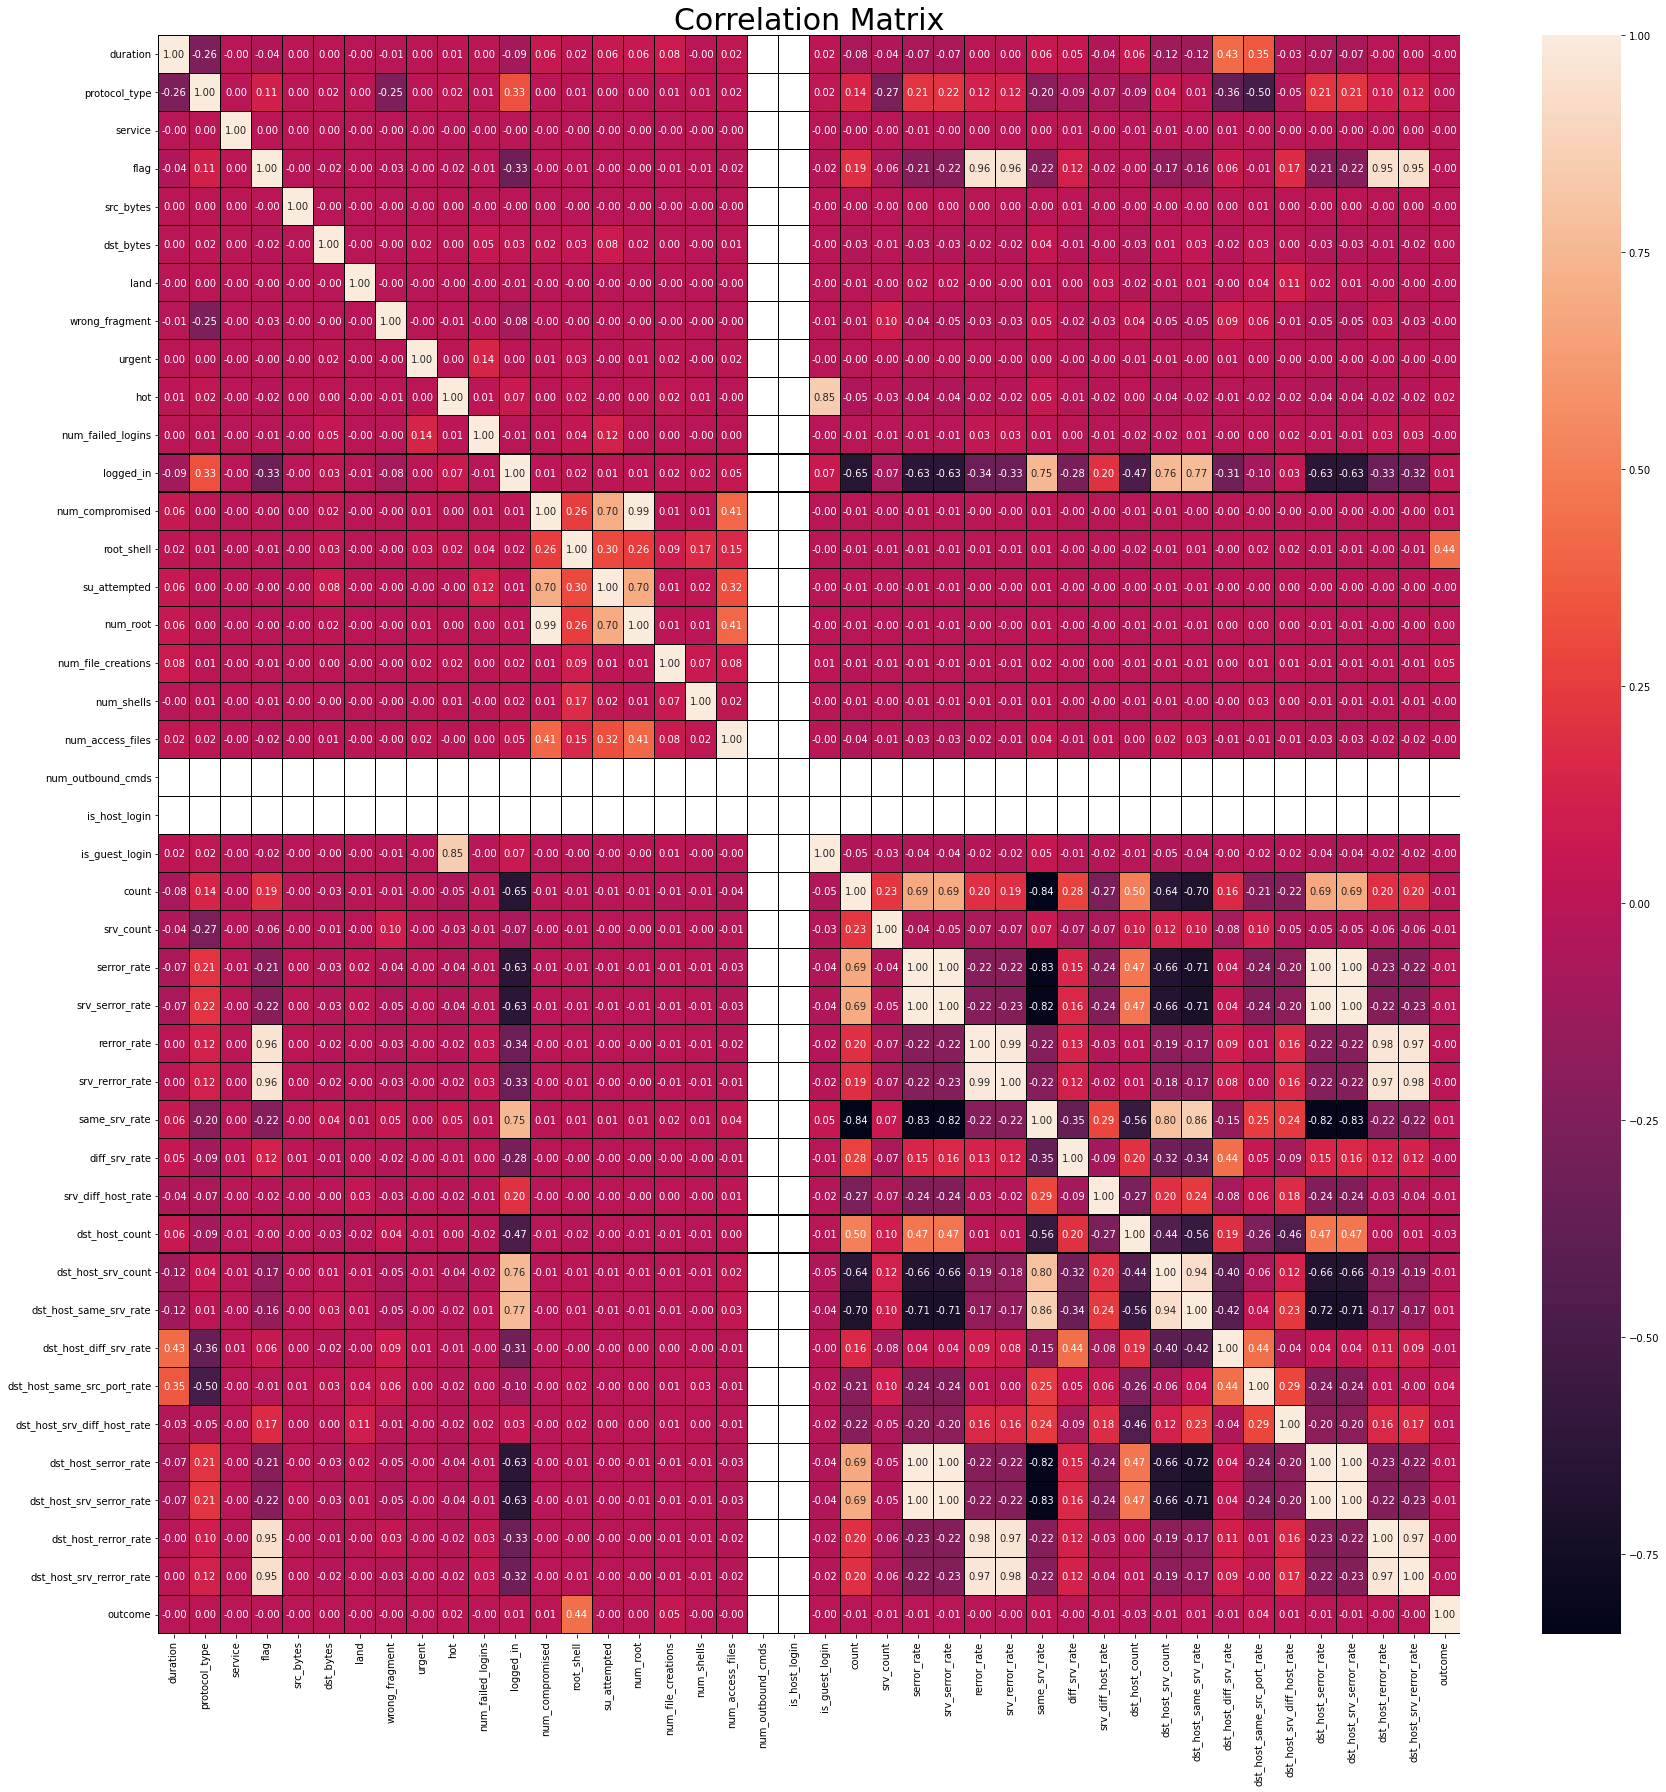

In [10]:
# Correlation Matrix
plt.figure(figsize=(25, 25))
sns.heatmap(dataset.corr(), annot=True, linewidths=0.1, fmt=".2f", linecolor="black")
plt.title("Correlation Matrix", fontsize=30)
plt.tight_layout()
plt.show()

Histogram distributions of categorical input features.

10


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

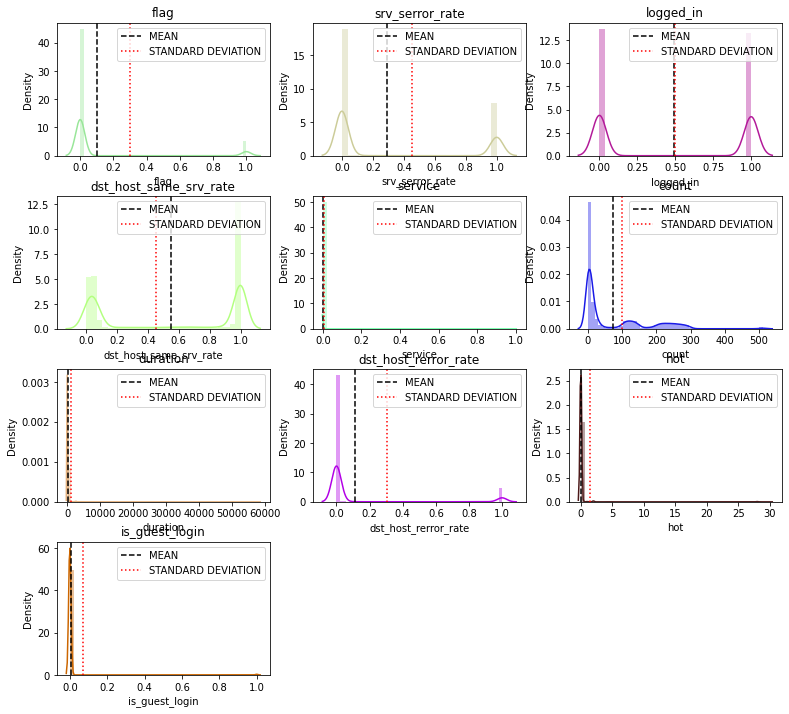

In [11]:
import random

features = ['flag', 'srv_serror_rate', 'logged_in', 'dst_host_same_srv_rate', 'service', 'count', 'duration', 'dst_host_rerror_rate', 'hot', 'is_guest_login']
features_length = len(features)
print(features_length)

#generate a random color for each feature plot
colors = []
for feature in features:
  color = []
  for i in range(0, 3):
    c = round(random.randint(0,255)/255, 1)
    color.append(c)  
  colors.append(tuple(color))



import itertools

plt.figure(figsize=(13, 12))
for i, j, k in itertools.zip_longest(features, range(features_length), colors):
    plt.subplot(4, 3, j+1)
    sns.distplot(dataset[i], color = k)
    plt.title(i)
    plt.subplots_adjust(hspace = 0.3)
    plt.axvline(dataset[i].mean(), color = "black", linestyle="dashed", label="MEAN")
    plt.axvline(dataset[i].std(), color = "red", linestyle="dotted", label="STANDARD DEVIATION")
    plt.legend(loc="upper right")


In [12]:
#List statistical information including the mean and standard deviation. 
dataset[features].describe()

,flag,srv_serror_rate,logged_in,dst_host_same_srv_rate,service,count,duration,dst_host_rerror_rate,hot,is_guest_login
count,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000
mean,0.101054,0.291551,0.491490,0.553222,0.000076,74.385593,132.025181,0.110463,0.100174,0.004705
std,0.301401,0.453567,0.499929,0.456236,0.008692,100.335945,1224.157053,0.306097,1.426798,0.068433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.050000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.770000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,132.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,511.000000,58329.000000,1.000000,30.000000,1.000000


The outcome is oversampled.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


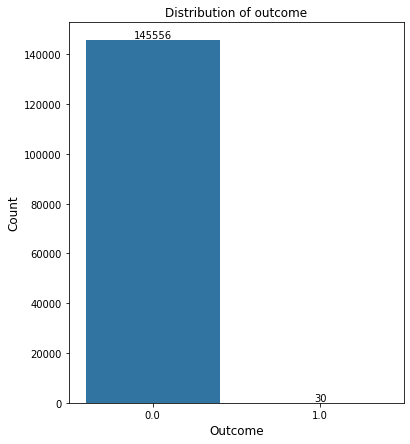

In [13]:
# Distribution of target class
plt.figure(figsize=(6, 7))
axs = sns.countplot(dataset['outcome'])
plt.title('Distribution of outcome', fontsize=12)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Count Annotation
for rec in axs.patches:
    axs.annotate(format(rec.get_height(), '.0f'), (rec.get_x() + rec.get_width() / 2.0, rec.get_height()), ha='center', va='center', xytext=(0, 5), textcoords = 'offset points', fontsize=10)


In [14]:
#Normalizing the data
from types import LambdaType
data = dataset.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))


In [15]:
data.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.96,0.0,1.0,0.89,1.00,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.93,0.0,1.0,0.95,1.00,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.89,0.0,1.0,0.97,1.00,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.85,0.0,1.0,0.97,1.00,1.0,1.0,1.0,1.0,1.0
4,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.81,0.0,1.0,0.98,1.00,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.00,0.0,1.0,0.92,0.99,1.0,1.0,1.0,1.0,1.0
96,1.0,0.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,...,0.00,0.0,1.0,0.95,0.99,1.0,1.0,1.0,1.0,1.0
97,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.00,0.0,1.0,0.83,0.98,1.0,1.0,1.0,1.0,1.0
98,1.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,...,0.00,0.0,1.0,0.94,0.98,1.0,1.0,1.0,1.0,1.0


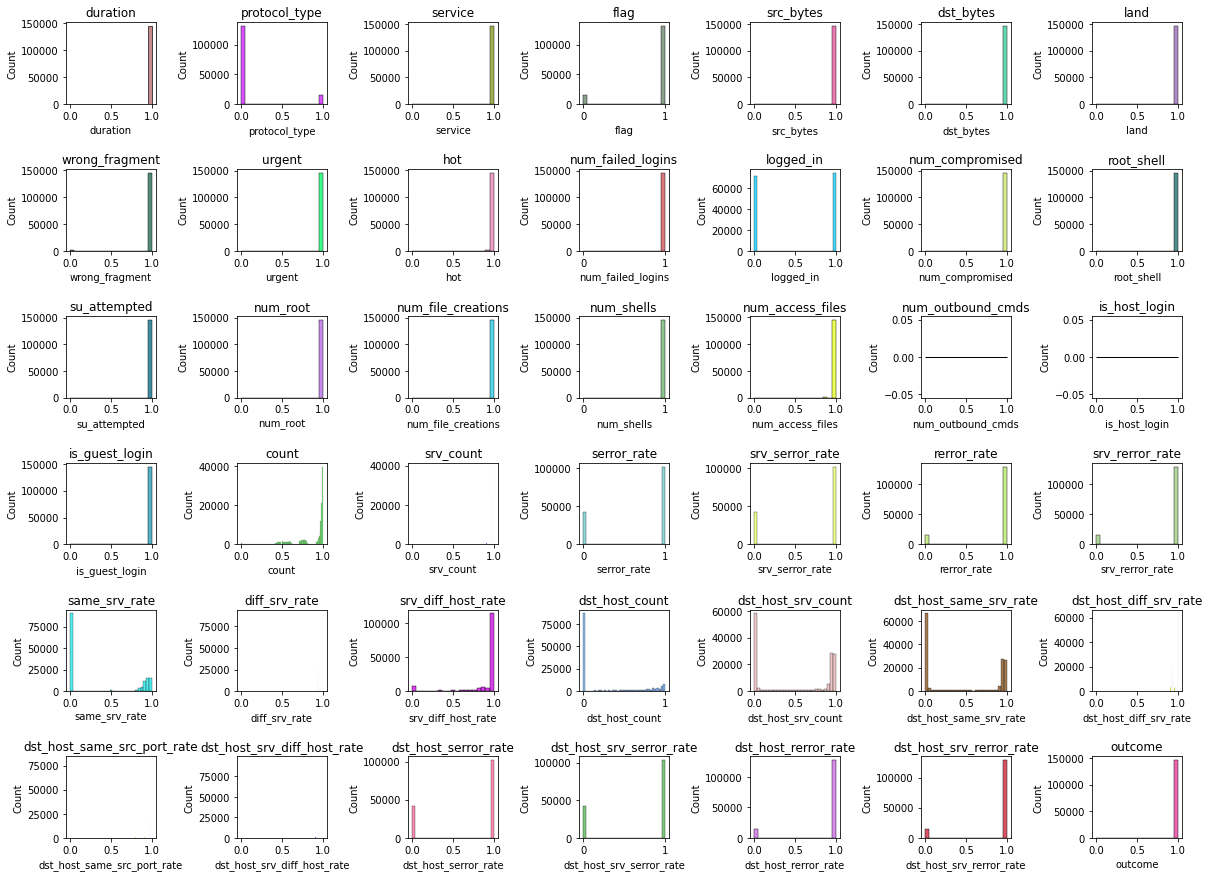

In [16]:
column_length = len(data.columns)
colors = []
for feature in data.columns:
  color = []
  for i in range(0, 3):
    c = round(random.randint(0,255)/255, 1)
    color.append(c)  
  colors.append(tuple(color))

plt.figure(figsize=(20, 15))
for i, j, k in itertools.zip_longest(data.columns, range(column_length), colors):
    plt.subplot(column_length/7, column_length/6, j+1)
    sns.histplot(data[i], color = k)
    plt.title(i)
    plt.subplots_adjust(hspace = 0.8, wspace =0.9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa70c253750>,
      dtype=object)

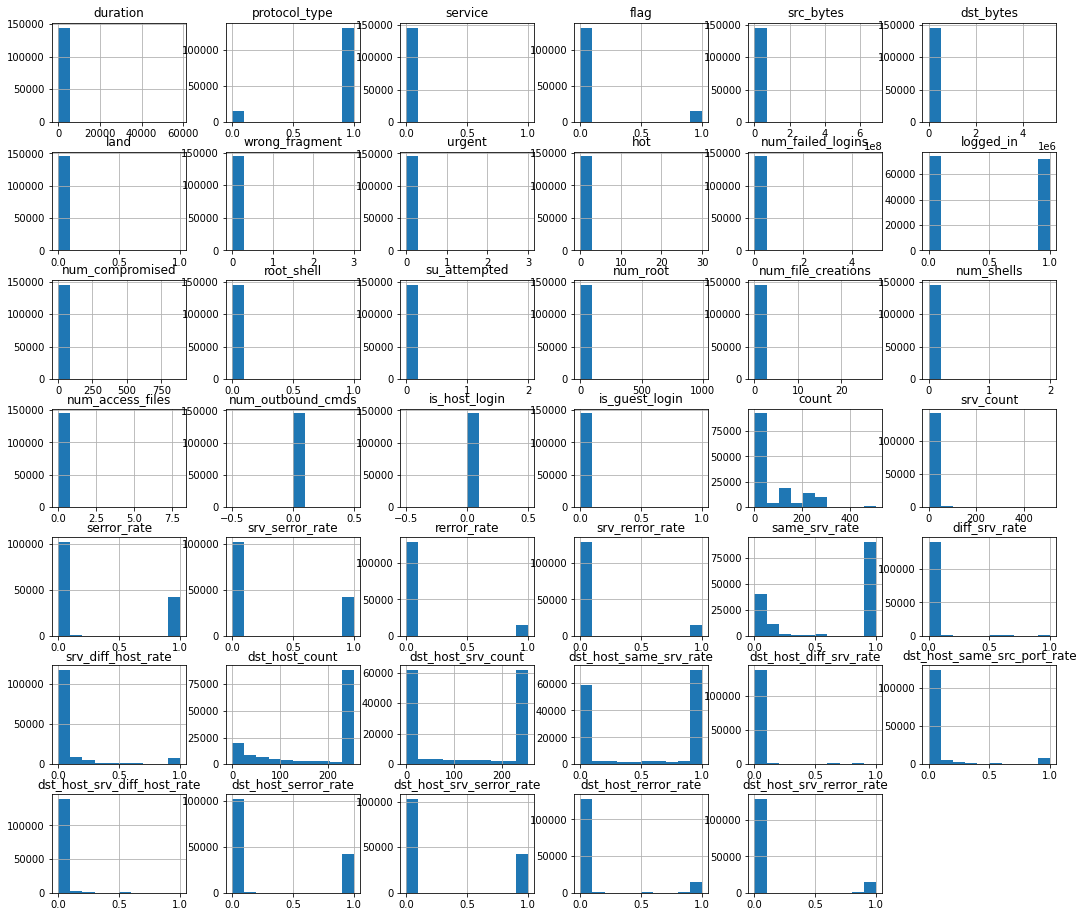

In [17]:
dataset.drop('outcome', axis='columns').hist(figsize=(18,16))